In [29]:
import gymnasium as gym

import torch
import torch.nn as nn
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from IPython import display
import matplotlib.pyplot as plt

In [30]:
env = gym.make("CartPole-v1")
state, _ = env.reset()

In [31]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
state_dim, action_dim

(4, 2)

In [32]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=state_dim, action_dim=action_dim, has_continuous_action_space=True, action_std_init=0.6):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space
        
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)


        self.actor = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, action_dim),
                        nn.Softmax(dim=-1)
                    )
        
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        

    def act(self, state):
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()

    def evaluate(self, state, action):  
        action_probs = self.actor(state)
        dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_val = self.critic(state)
        
        return action_logprobs, state_val, dist_entropy



# ppo_agent = ActorCritic()
# inp = torch.rand(1, state_dim)
# action, _, _ = model.act(inp)
# model.evaluate(inp, action)

In [33]:
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]

In [34]:
class PPO:
    def __init__(self, state_dim=state_dim, action_dim=action_dim, lr_actor=0.0003 , lr_critic=0.001 , gamma=0.99 , K_epochs=80, eps_clip=0.2):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()
        self.time_buffer_clear = 0

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        with torch.no_grad():
            state = torch.from_numpy(state).to(device)
            action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards).float().to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        advantages = rewards.detach() - old_state_values.detach()

        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

        if self.time_buffer_clear == 3:
            self.time_buffer_clear = 0
            self.buffer.clear()
        self.time_buffer_clear  += 1

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
  
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
ppo_agent = PPO()
# ppo_agent.load(f"ppo_actor.pt")
list_episodes_reward = []
time_step = 0
i_episode = 0

Episode: 903 Timestep: 50000 Reward: 279.64


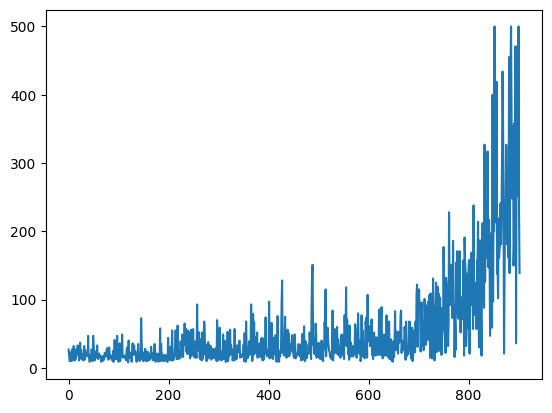

------------------------
model saved
------------------------


In [35]:
max_ep_len = 1000
update_timestep = max_ep_len * 4 
max_training_timesteps = int(3e6) 
env = gym.make("CartPole-v1")


print_freq = max_ep_len * 10
save_model_freq = int(1e4)

print_running_reward = 0
print_running_episodes = 0



while time_step <= max_training_timesteps:
    state, _ = env.reset()
    current_ep_reward = 0
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step += 1
        current_ep_reward += reward


        if time_step % update_timestep == 0:
            ppo_agent.update()

        if time_step % print_freq == 0:
            display.clear_output()
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)
            print(f"Episode: {i_episode} Timestep: {time_step} Reward: {print_avg_reward}")
            print_running_reward = 0
            print_running_episodes = 0
            plt.plot(list_episodes_reward)
            plt.show()

        if time_step % save_model_freq == 0:
            print('------------------------')
            ppo_agent.save(f"ppo_actor.pt")
            print('model saved')
            print('------------------------')
        
        if done:
            break
    
    list_episodes_reward.append(current_ep_reward)
    print_running_reward += current_ep_reward
    print_running_episodes += 1

    i_episode += 1
